# UK Crime Data


## Introduction

We have been tasked with taking large data sets, mainly for London, and trying to extract some meaningful information out of them. After doing some exploratory data analysis, and using our data cleaning skills, we will perform some simple hypothesis testing, to see whether or not the data is strong enough to confirm our theories. 

## Data - APIs, CSVs, XLS and PDFs

Our largest data set that we downloaded was in CSV form (https://data.police.uk/data/archive/). It is a massive collection of every crime commited in the UK, and we downloaded from 2011 to 2014, subsetting on London, to make it more managable. It is quite clean but will require a few changes to make it optimal for our use.

# Hypotheses 

1 - Are variations in the data for violent crime in Camden explained by natural variation?
    Our null hypothesis for this would be p1=p2, where p1,p2 are the probabilities of violent crime occuring, in       two successive months. 

# EDA

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import requests
import pymongo
from pymongo import MongoClient
import json
import data_cleaning as dc
import hypothesis_tests as hyp
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

Firstly, looking at the large CSV files:


In [2]:
data = pd.read_csv('London Crime Data 2011 to 2014/2011-01-metropolitan-street.csv')

In [3]:
data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
1,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.140619,51.583427,On or near Rams Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
2,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
3,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
4,NaN,2011-01,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN


In [4]:
data.shape

(99099, 12)

In [5]:
data.isna().sum()

Crime ID                 99099
Month                        0
Reported by                  0
Falls within                 0
Longitude                    0
Latitude                     0
Location                     0
LSOA code                    0
LSOA name                    0
Crime type                   0
Last outcome category    99099
Context                  99099
dtype: int64

Looks like 'Crime ID', 'Last outcome category' and 'Context' are useless columns! We'll check to see if they're left empty in other months:

In [6]:
data = pd.read_csv('London Crime Data 2011 to 2014/2013-01-metropolitan-street.csv')
data.shape


(84334, 12)

In [7]:
data.isna().sum()

Crime ID                 21118
Month                        0
Reported by                  0
Falls within                 0
Longitude                 1048
Latitude                  1048
Location                     0
LSOA code                 1048
LSOA name                 1048
Crime type                   0
Last outcome category    21118
Context                  84334
dtype: int64

'Crime ID', 'Last outcome category' and 'Context' are still full of nulls, and we don't need them for our analysis anyway. There are 1048 nulls in this dataset, which are crimes that have no set locations, hence the nulls for all the location parameters. These *will* need dealing with, as we will want to use location as part of our hypotheses.

insert: 2 functions from datacleaning.py that remove the 3 columns, and fill the nulls, and iterate through the whole dataset for it. 

# Hypothesis Testing

## Hypothesis One

We want to explore how violent crime has changed over time in London. Is it genuinely getting worse/better or can the variations be explained by normal variation in the data?

So, for example, comparing one month to another, our null hypothesis would be : p1=p2

where p1,p2 are the mean number of violent crimes committed in those months. 

Lets have a look to see how the proportion of violent crime is changing in Camden:

In [8]:
violent_crime_data = pd.DataFrame(columns=['Borough','2011-01','2011-02','2011-03','2011-04','2011-05','2011-06','2011-07','2011-08','2011-09','2011-10','2011-11','2011-12','2012-01','2012-02','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09','2012-10','2012-11','2012-12','2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12'])
violent_crime_data = violent_crime_data.append({'Borough': 'Camden'}, ignore_index=True)
##create a table for our data

In [9]:
now = []
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
years = ['2011','2012','2013','2014']
dates = []
for y in years:
    for x in months:
        a = hyp.vcp('Camden',y,x)
        now.append(a)
        dates.append('{}-{}'.format(y,x))
        violent_crime_data['2011-{}'.format(x)][0] = a    

#use our function vcp, which returns the proportion of violent crime in any month, and then we iterate through all our data

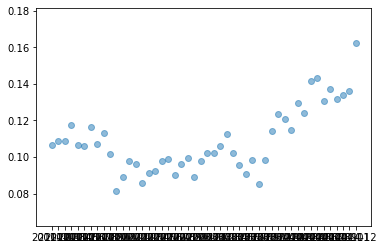

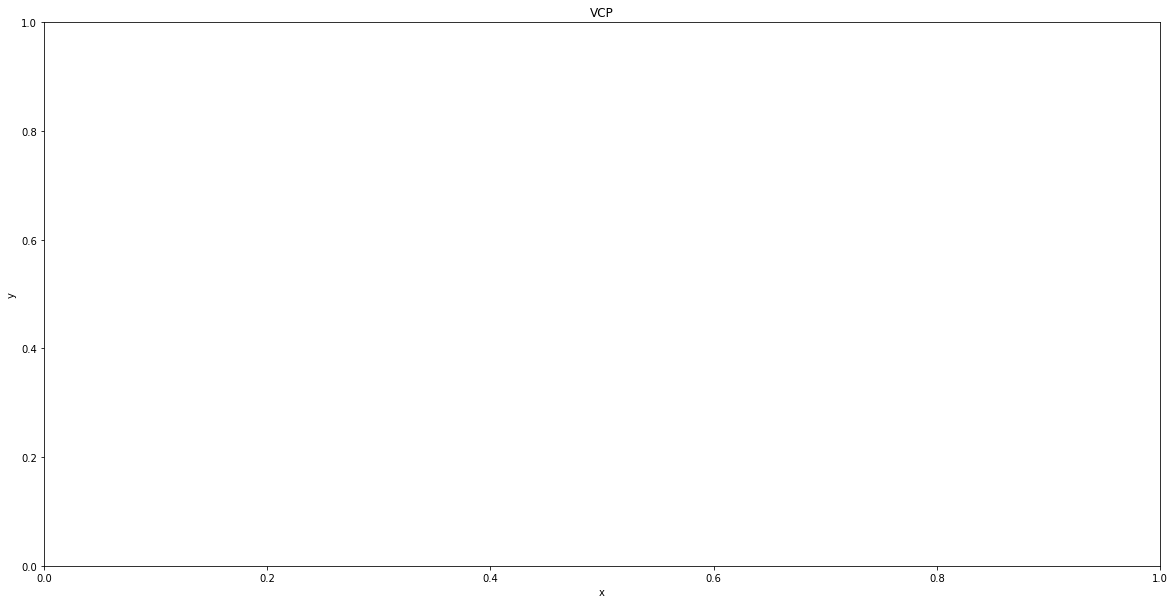

In [10]:
x = dates
y = now

# Plot
plt.scatter(x, y, alpha=0.5)
plt.figure(figsize=(20,10))
plt.title('VCP')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Obiously need to improve this plot

There seems to be a pretty big jump between October and November 2011 - is this just normal varience or is this a change?

In [11]:
october_data = pd.read_csv('London Crime Data 2011 to 2014/2011-10-metropolitan-street.csv')

violent1 = len(october_data.loc[(october_data['LSOA name'].str.contains("Camden")) & \
                     ((october_data['Crime type'] == "Violent crime")|(october_data['Crime type'] == "Violence and sexual offences"))])

n1 = len(october_data.loc[(october_data['LSOA name'].str.contains("Camden"))])

p1 = violent1/n1

mu1 = n1*p1

var1 = n1*p1*(1-p1)

november_data = pd.read_csv('London Crime Data 2011 to 2014/2011-11-metropolitan-street.csv')

violent2 = len(november_data.loc[(november_data['LSOA name'].str.contains("Camden")) & \
                     ((november_data['Crime type'] == "Violent crime")|(november_data['Crime type'] == "Violence and sexual offences"))])

n2 = len(november_data.loc[(november_data['LSOA name'].str.contains("Camden"))])

p2 = violent2/n2

mu2 = n2*p2

var2 = n2*p2*(1-p2)

print("Dist1 has p-value {} and sample size {}".format(p1,n1))
print("Dist2 has p-value {} and sample size {}".format(p2,n2))

Dist1 has p-value 0.10152890587673197 and sample size 4186
Dist2 has p-value 0.0815552394499763 and sample size 4218


In [12]:
p_hat = (n1*p1 + n2*p2)/(n1+n2)
critical_value = 1.96

In [13]:
z = (p1-p2)/((p_hat*(1-p_hat)*((1/n1)+(1/n2)))**0.5)
z>1.96

True

We reject the null! If the police officers were trying a new method to tackle violent crime this month, they can see this as genuine evidence that their method is making a difference!

In [14]:
print(violent2)
print(n2)
print(p1)
stats.binom.cdf(k=violent2, n=n2, p=p1, loc=0)
#makes sense we are rejecting, the probability of getting this number of
#violent crimes at the same parameter values as the month before is tiny!

344
4218
0.10152890587673197


5.472003326693572e-06

Try another?

## Hypothesis Two

# Conclusion